# Effect of UBI on wealth by black/non-black

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import microdf as mdf

In [2]:
mdf.set_plot_style(dpi=400)

## Load data

In [3]:
COLS = ['networth', 'race', 'wgt', 'famstruct', 'kids']
scf_raw = mdf.read_stata_zip(
    'https://www.federalreserve.gov/econres/files/scfp2016s.zip',
    columns=COLS)

## Preprocess

In [4]:
scf = scf_raw.copy(deep=True)

Map codes from https://sda.berkeley.edu/sdaweb/docs/scfcomb/DOC/hcbk0001.htm#RACE

In [5]:
scf['race2'] = np.where(scf.race.isin([1, 3]), 'White',  # Including Hispanic.
                        np.where(scf.race == 2, 'Black', 'Other'))

famstruct 4 and 5 indicate married/LWP (living with partner)

In [6]:
scf['numper'] = 1 + scf.famstruct.isin([4, 5]) + scf.kids

## Baseline

In [7]:
mdf.weighted_median(scf, 'networth', 'wgt')

97291.46093118282

In [8]:
mdf.weighted_mean(scf, 'networth', 'wgt')

689508.5643501689

In [9]:
scf.groupby('race2').apply(lambda x: pd.Series(
    [mdf.weighted_median(x, 'networth', 'wgt'), 
     mdf.weighted_mean(x, 'networth', 'wgt')], 
    index=['median', 'mean']))

,median,mean
race2,,
Black,16300.000000,139792.391639
Other,102000.000000,712185.328050
White,125180.651342,797950.404569


In [10]:
def median_wealth_by_race(df):
    return df.groupby('race2').apply(
        lambda x: mdf.weighted_median(x, 'networth', 'wgt'))

def mean_wealth_by_race(df):
    return df.groupby('race2').apply(
        lambda x: mdf.weighted_mean(x, 'networth', 'wgt'))

## UBI

In [11]:
def new_median(ubi_pp_pm):
    reform = scf.copy(deep=True)
    reform['ubi'] = ubi_pp_pm * reform.numper * 12
    reform.networth += reform.ubi
    return median_wealth_by_race(reform)

def new_mean(ubi_pp_pm):
    reform = scf.copy(deep=True)
    reform['ubi'] = ubi_pp_pm * reform.numper * 12
    reform.networth += reform.ubi
    return mean_wealth_by_race(reform)

In [12]:
ubi = pd.DataFrame({'ubi_pm': np.arange(0, 1001, 20)})

In [13]:
ubi[['black_median', 'other_median', 'white_median']] = ubi.apply(
    lambda row: new_median(row.ubi_pm), axis=1)
ubi[['black_mean', 'other_mean', 'white_mean']] = ubi.apply(
    lambda row: new_mean(row.ubi_pm), axis=1)

Calculate deltas.

In [14]:
ubi['white_minus_black_median'] = ubi.white_median - ubi.black_median
ubi['white_div_black_median'] = ubi.white_median / ubi.black_median

ubi['white_minus_black_mean'] = ubi.white_mean - ubi.black_mean
ubi['white_div_black_mean'] = ubi.white_mean / ubi.black_mean

## Graphs

Set "Other" to gray so that greens can be used for comparisons.

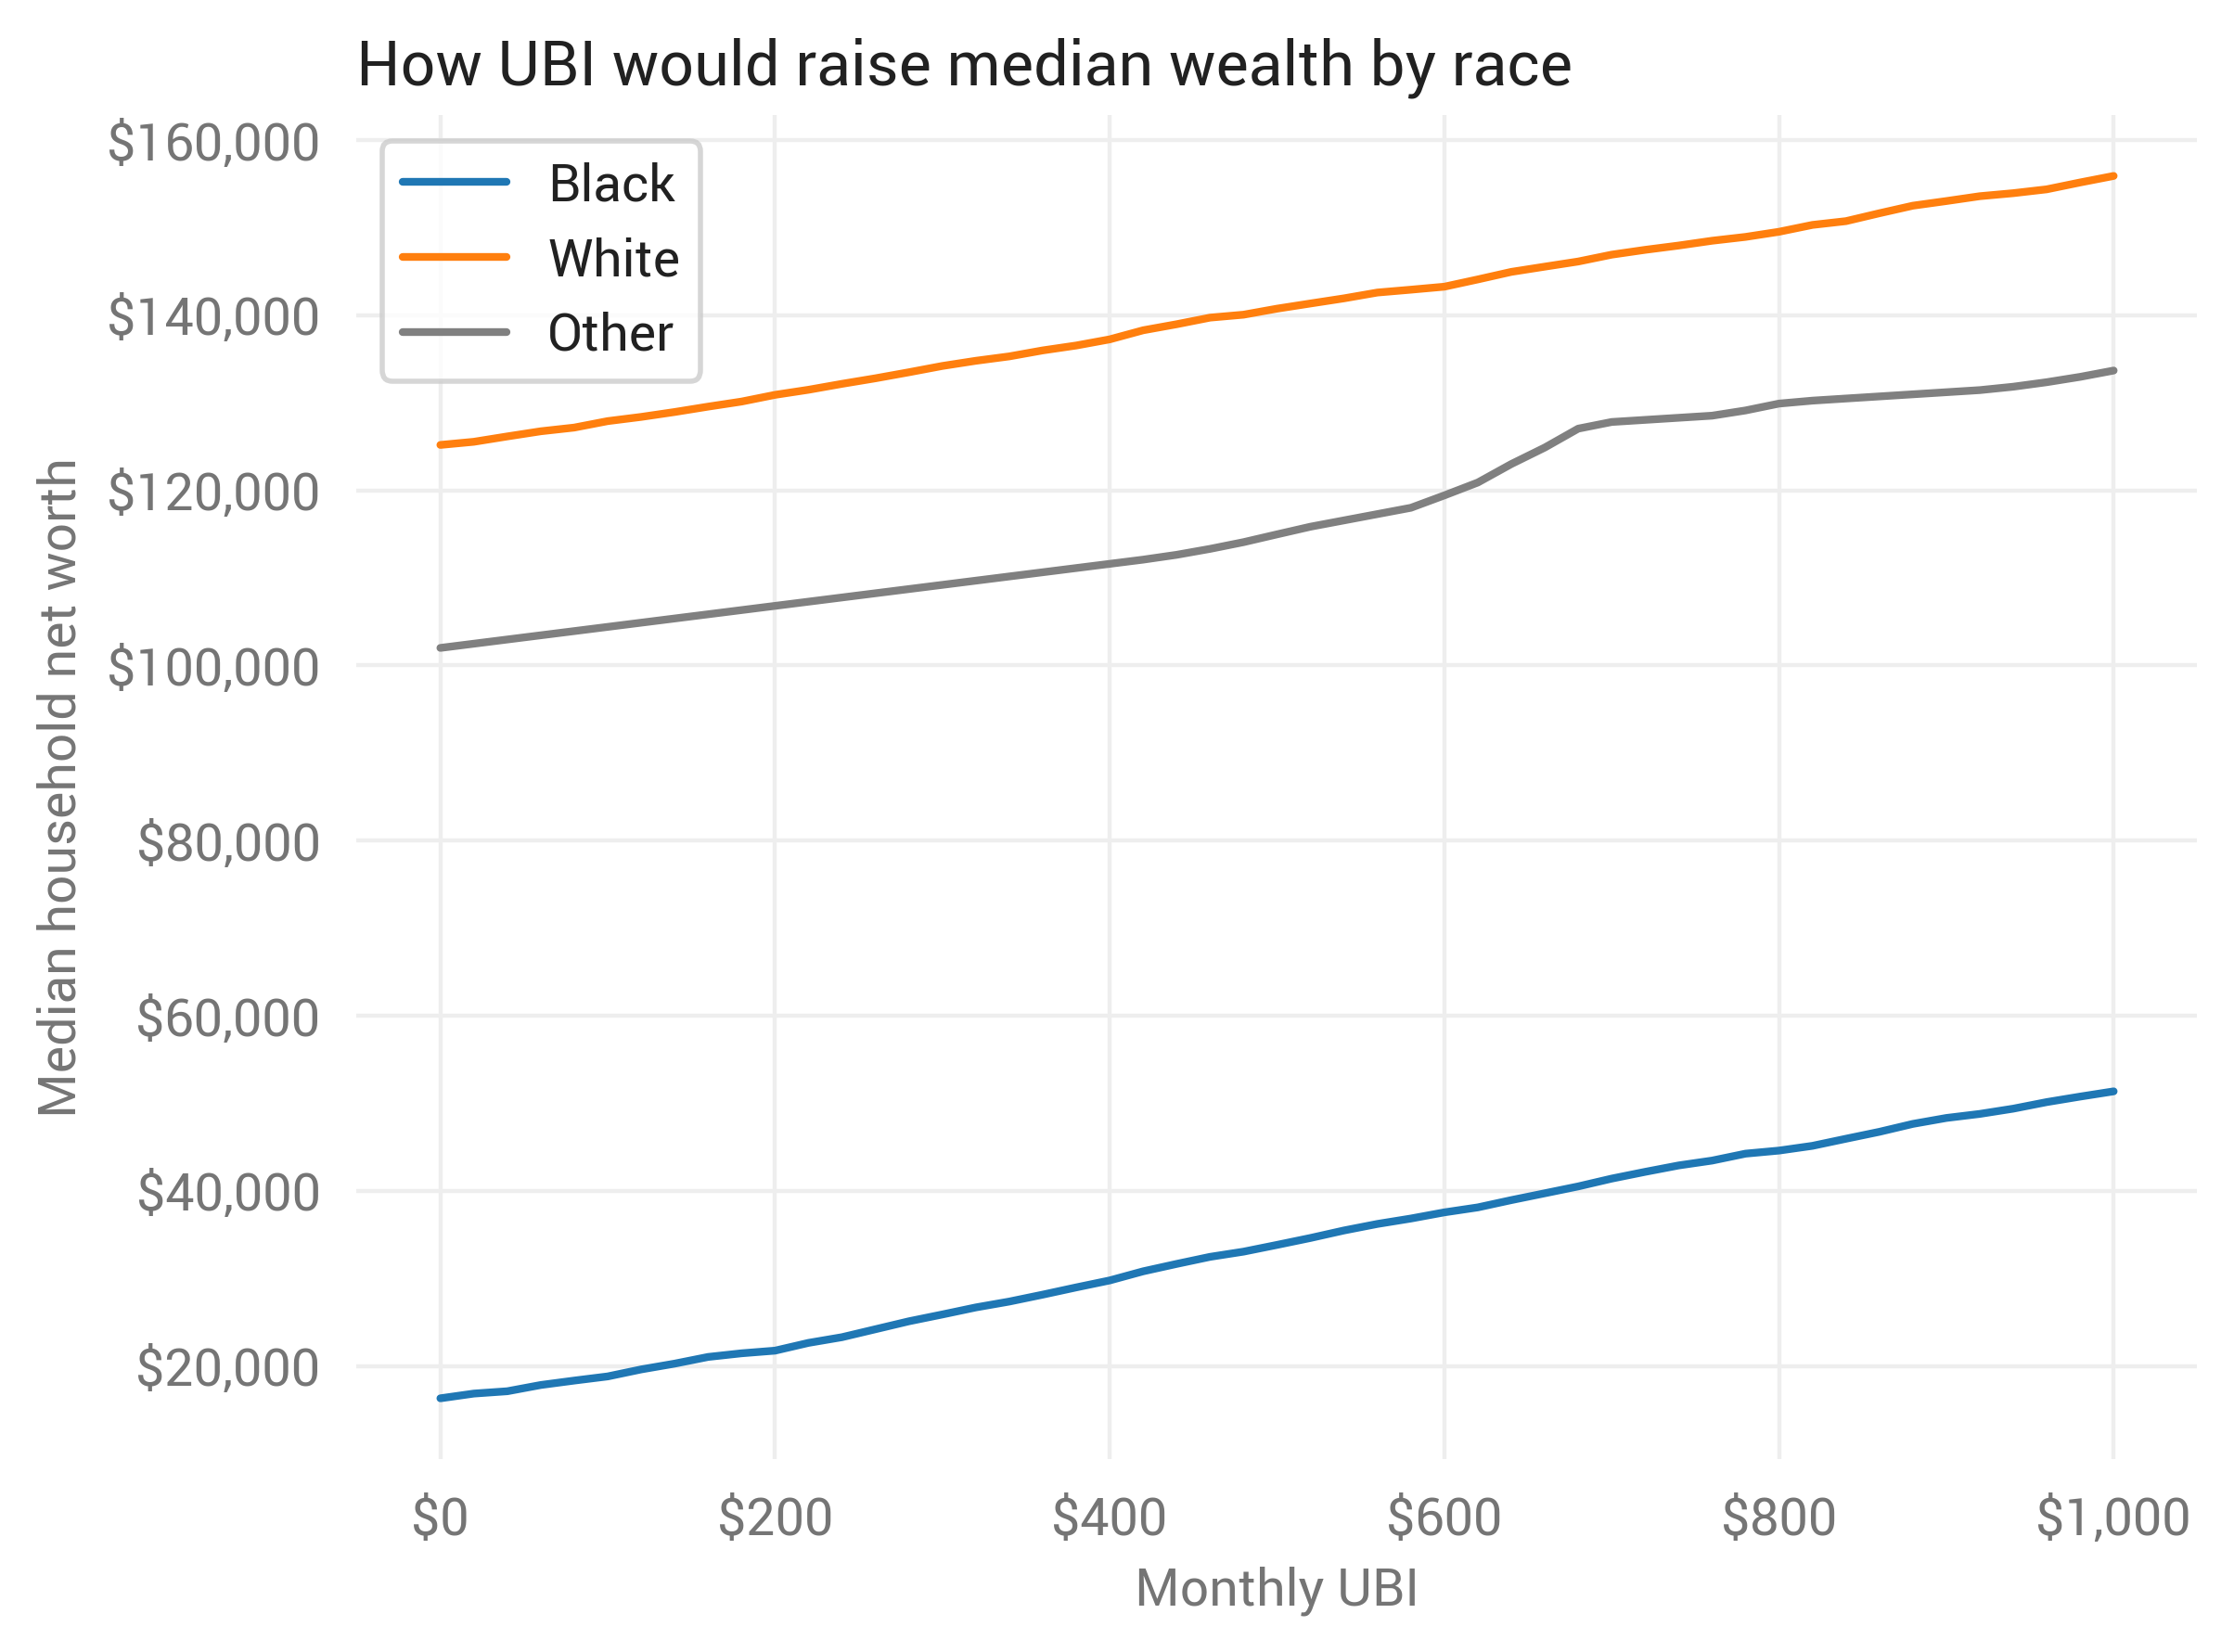

In [15]:
ax = ubi.plot(x='ubi_pm', y=['black_median', 'white_median', 'other_median'],
              color=[None, None, 'gray'])
plt.title('How UBI would raise median wealth by race', loc='left')
plt.legend(['Black', 'White', 'Other'])
plt.xlabel('Monthly UBI')
ax.xaxis.set_major_formatter(mdf.dollar_format())
plt.ylabel('Median household net worth')
ax.yaxis.set_major_formatter(mdf.dollar_format())
plt.show()

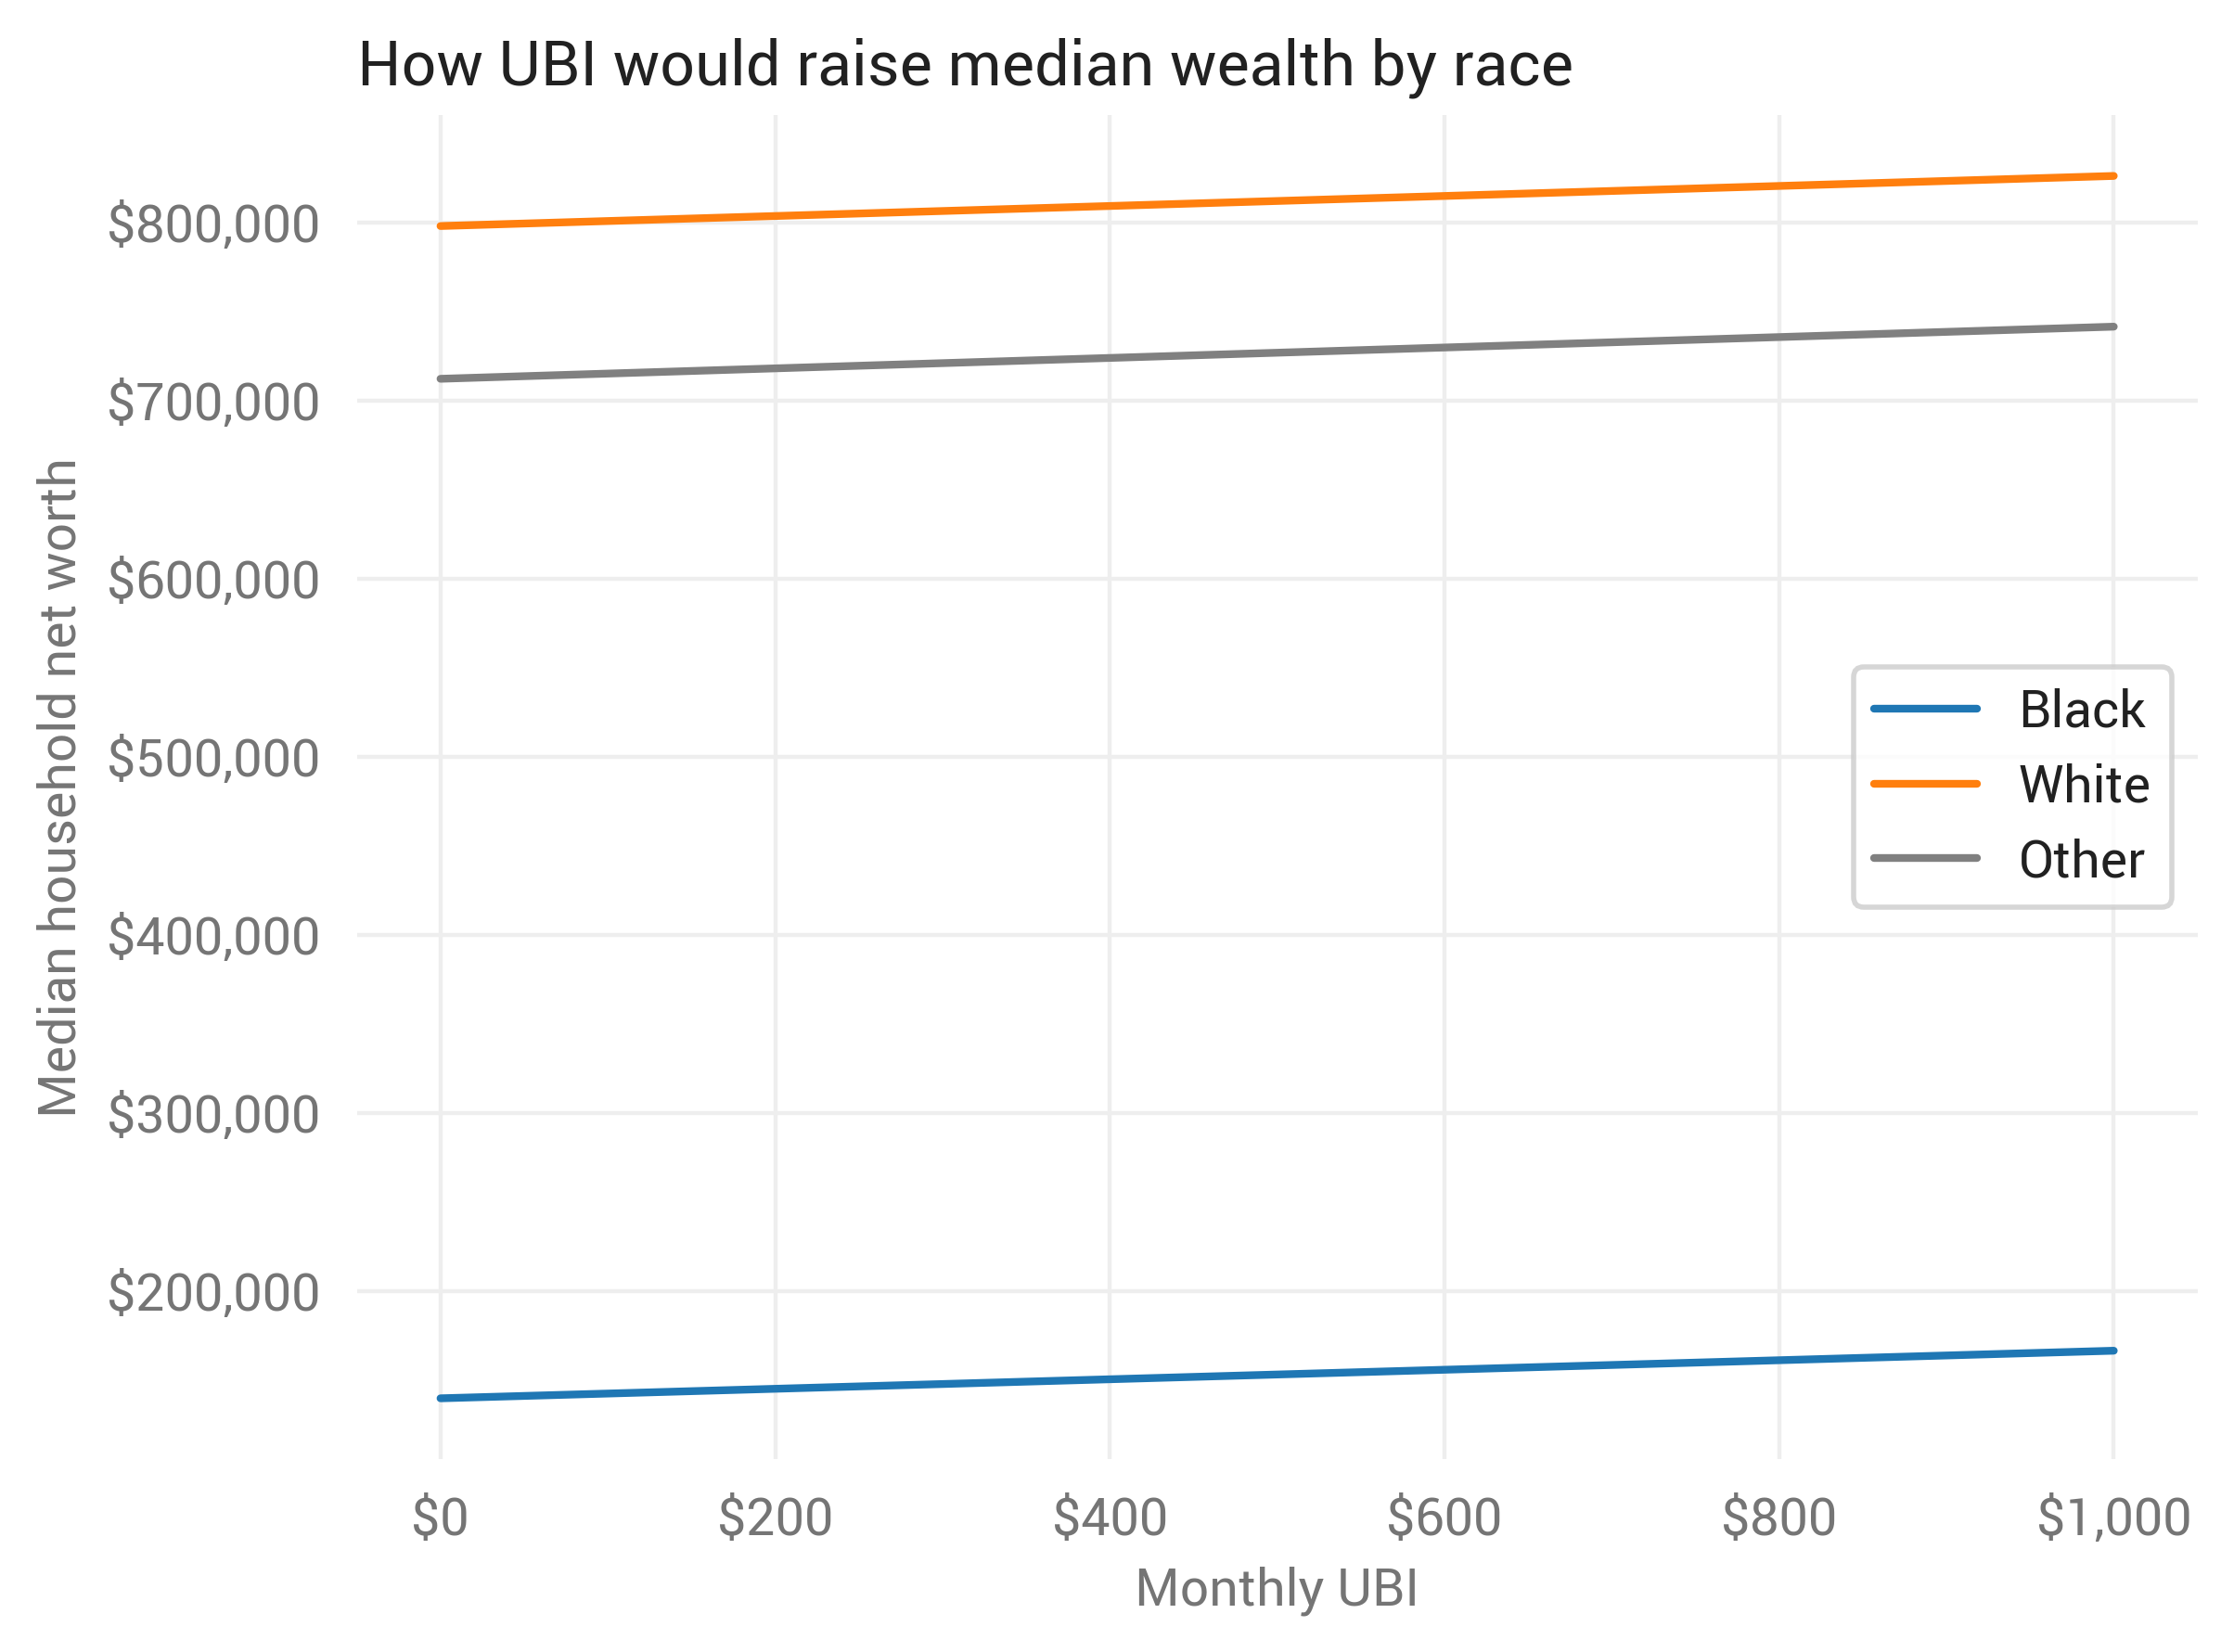

In [16]:
ax = ubi.plot(x='ubi_pm', y=['black_mean', 'white_mean', 'other_mean'],
              color=[None, None, 'gray'])
plt.title('How UBI would raise median wealth by race', loc='left')
plt.legend(['Black', 'White', 'Other'])
plt.xlabel('Monthly UBI')
ax.xaxis.set_major_formatter(mdf.dollar_format())
plt.ylabel('Median household net worth')
ax.yaxis.set_major_formatter(mdf.dollar_format())
plt.show()

In [17]:
greens = plt.get_cmap('Greens')

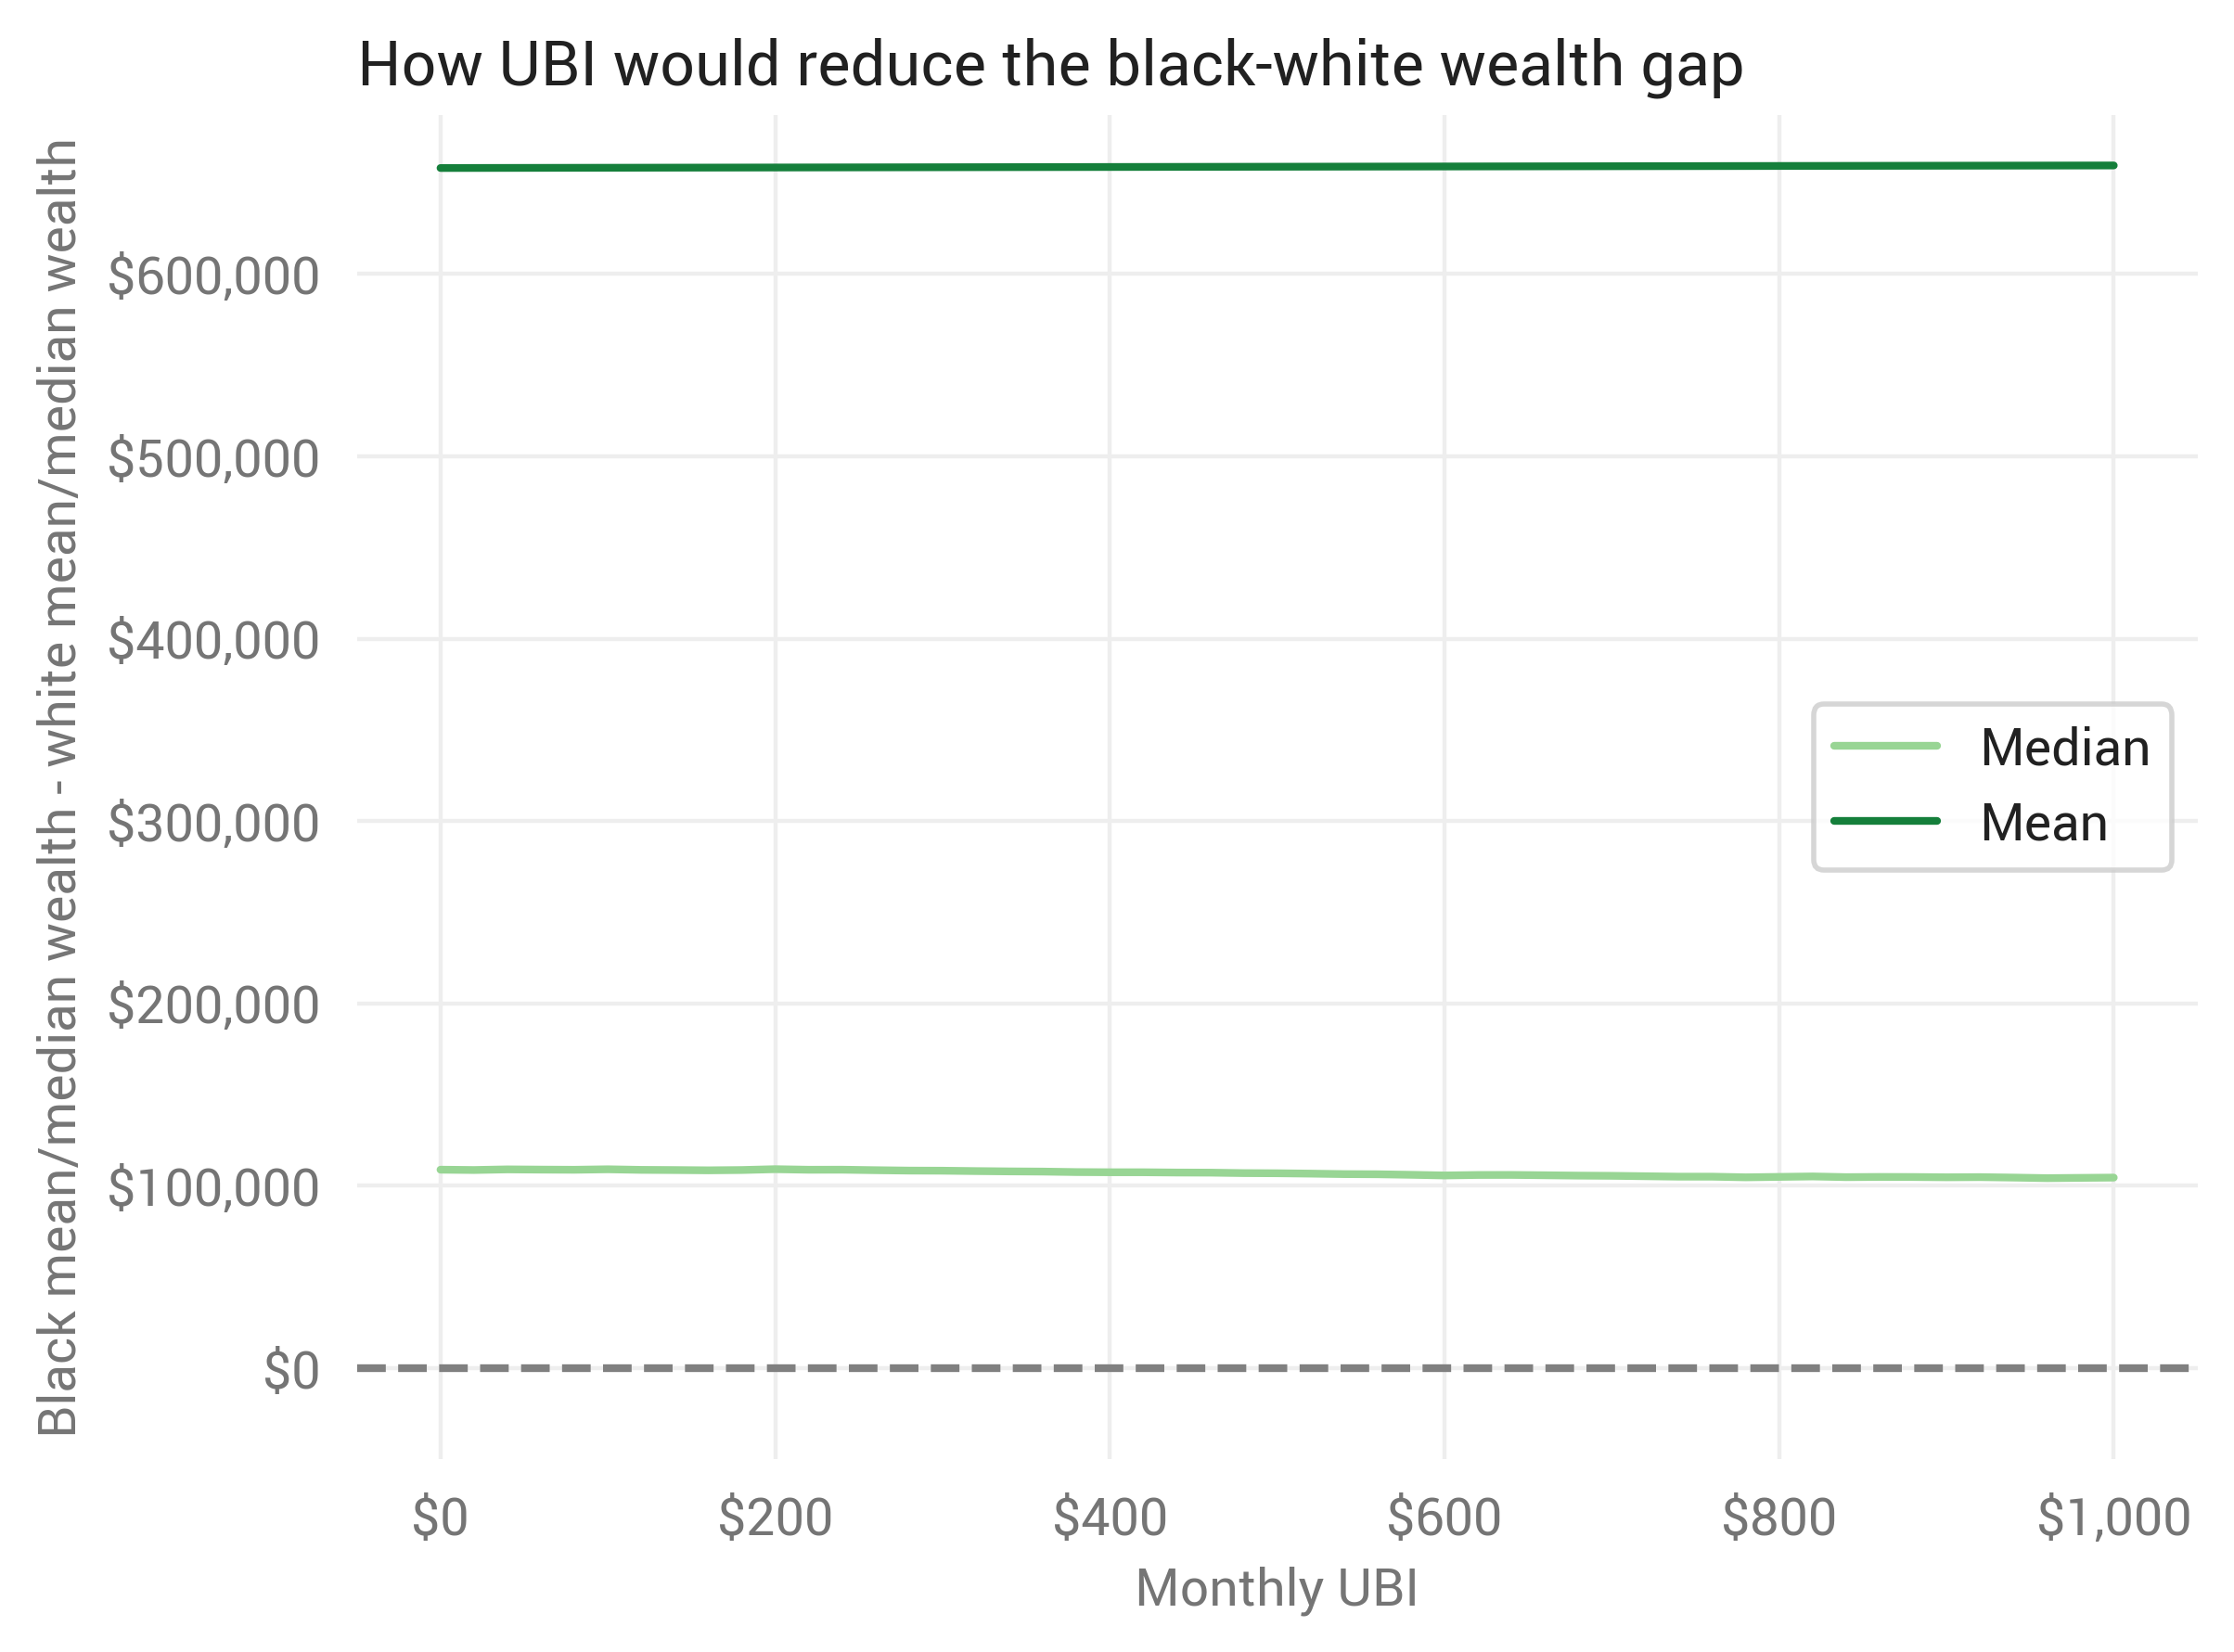

In [18]:
ax = ubi.plot(x='ubi_pm',
              y=['white_minus_black_median', 'white_minus_black_mean'],
              color=[greens(0.4), greens(0.8)])
plt.title('How UBI would reduce the black-white wealth gap', loc='left')
plt.legend(['Median', 'Mean'])
plt.xlabel('Monthly UBI')
plt.ylim(-50000, None)
plt.axhline(0, c='gray', ls='--')
ax.xaxis.set_major_formatter(mdf.dollar_format())
plt.ylabel('Black mean/median wealth - white mean/median wealth')
ax.yaxis.set_major_formatter(mdf.dollar_format())
plt.show()

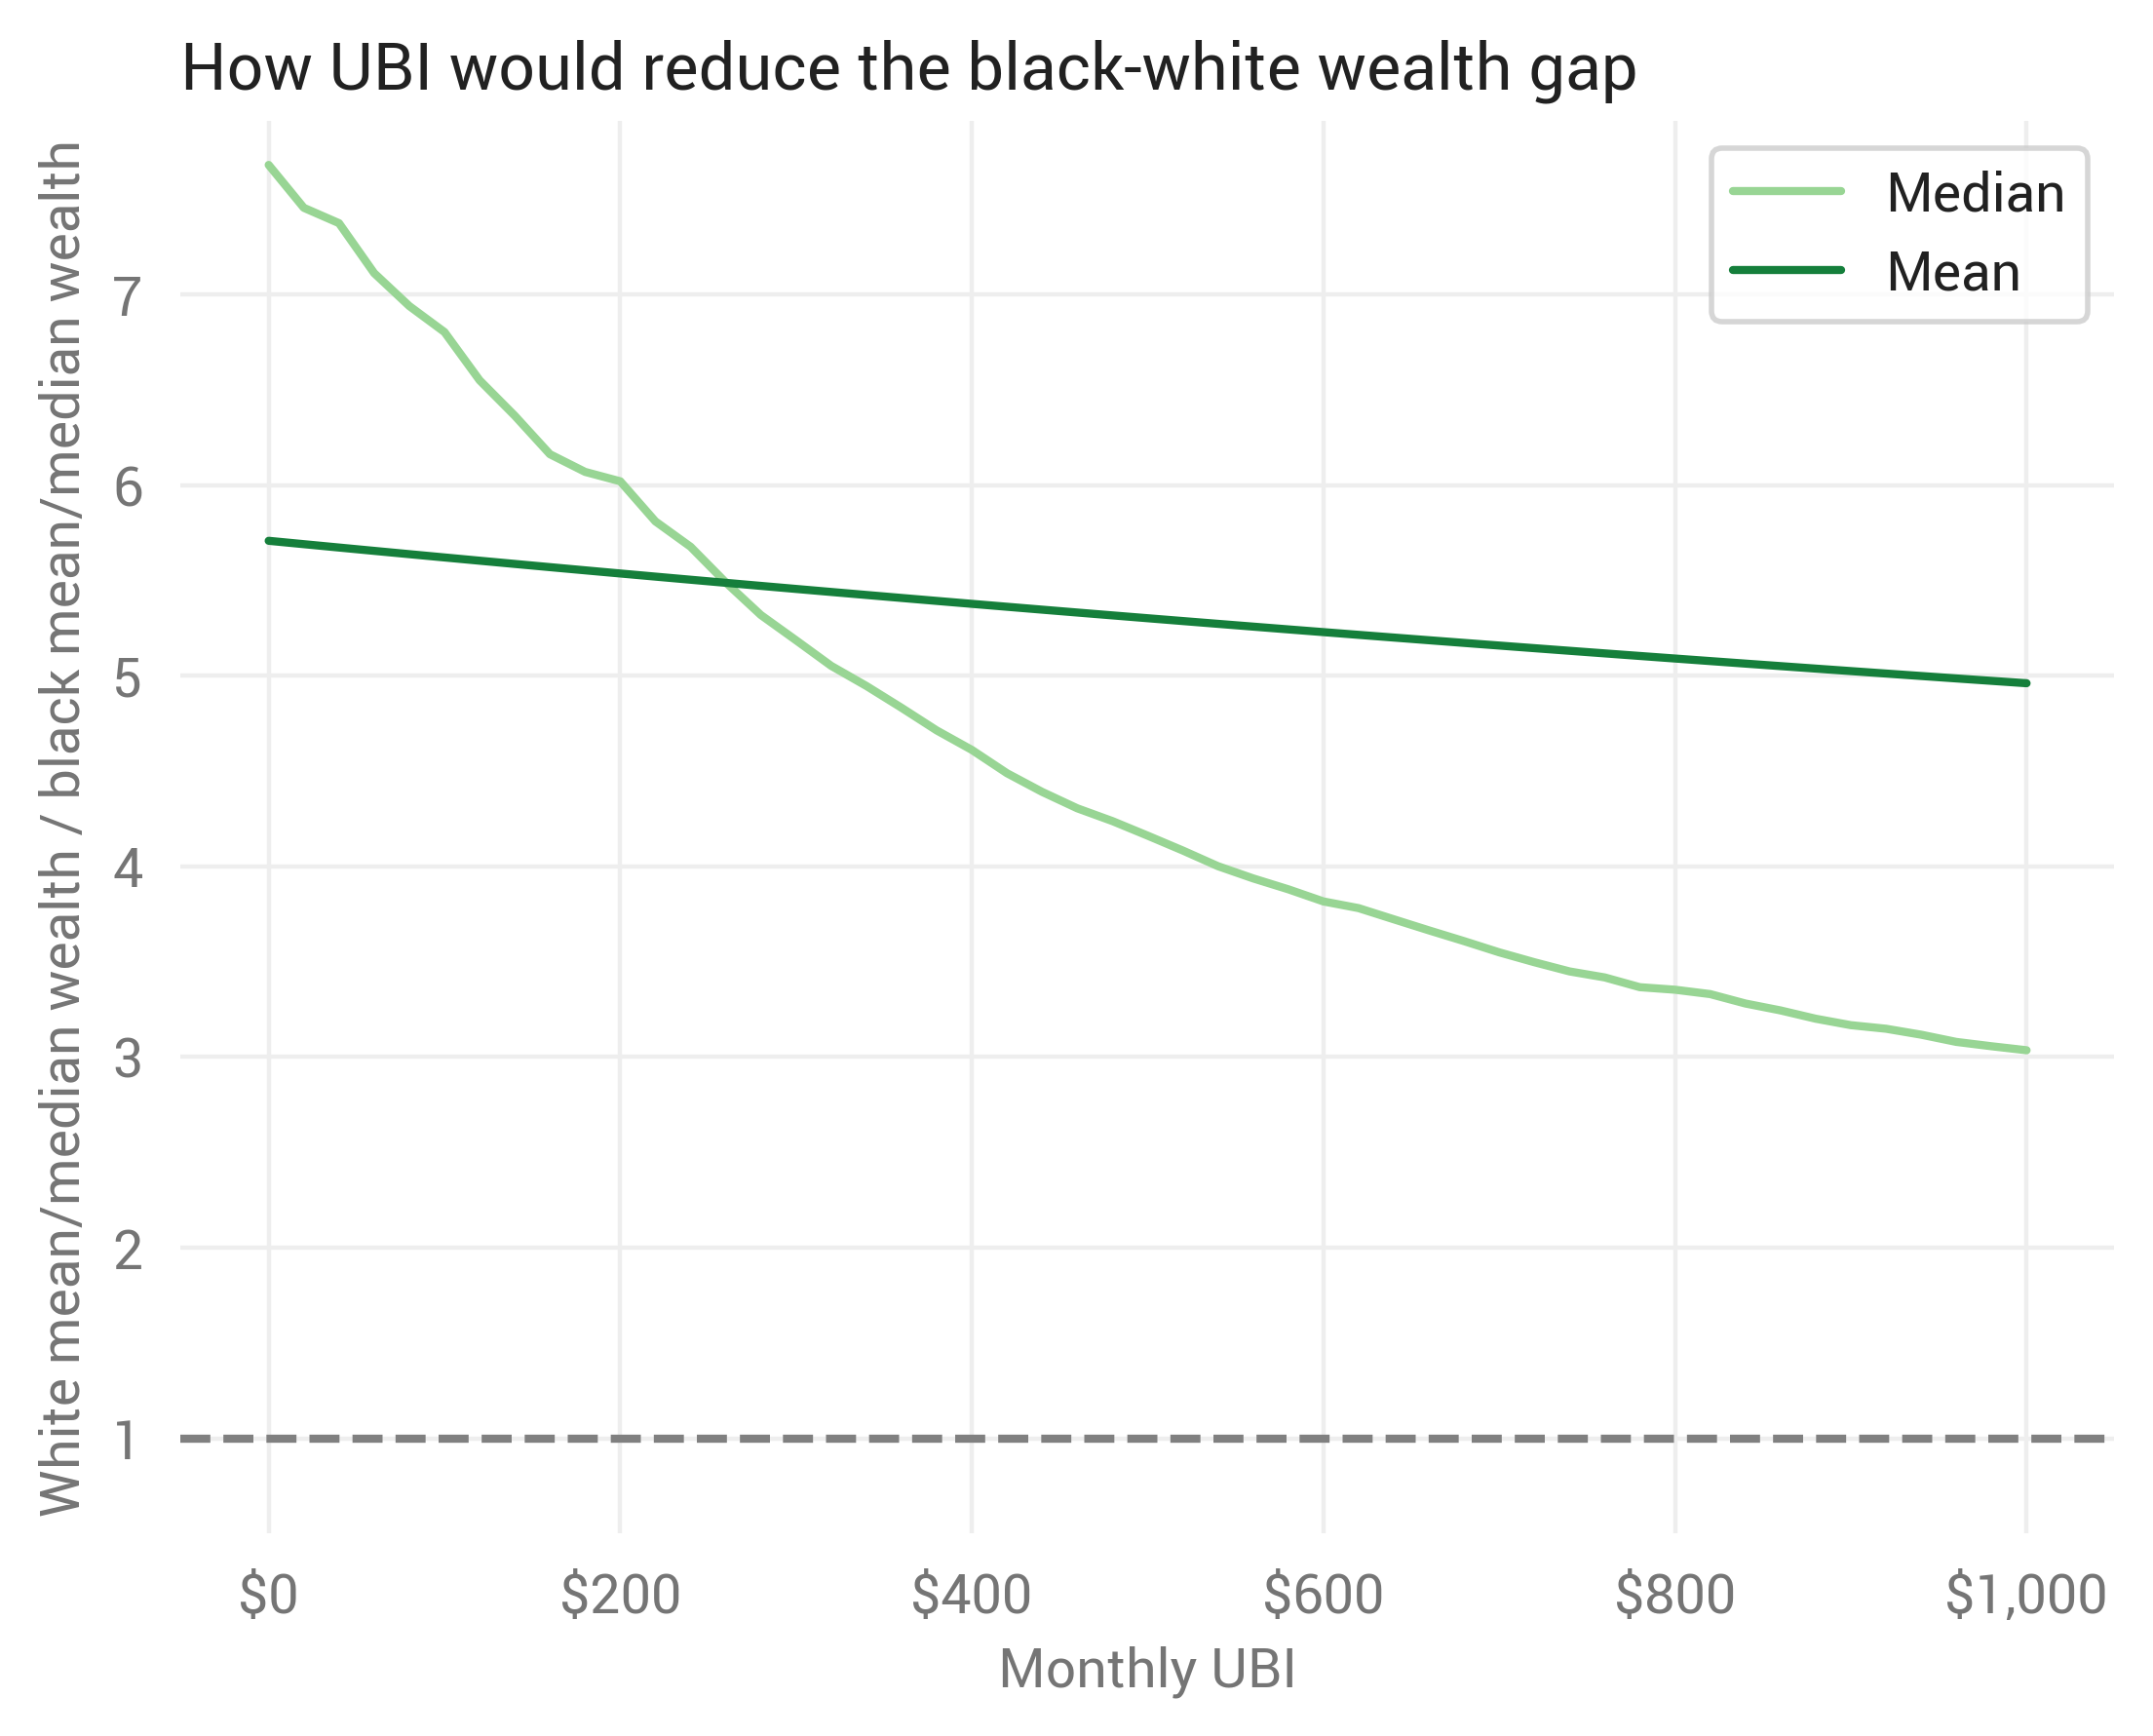

In [19]:
ax = ubi.plot(x='ubi_pm',
              y=['white_div_black_median', 'white_div_black_mean'],
              color=[greens(0.4), greens(0.8)])
plt.title('How UBI would reduce the black-white wealth gap', loc='left')
plt.legend(['Median', 'Mean'])
plt.xlabel('Monthly UBI')
plt.ylim(0.5, None)
plt.axhline(1, c='gray', ls='--')
ax.xaxis.set_major_formatter(mdf.dollar_format())
plt.ylabel('White mean/median wealth / black mean/median wealth')
plt.show()

A few data points.

In [20]:
ubi[ubi.ubi_pm.isin([0, 200, 1000])]

,ubi_pm,black_median,other_median,white_median,black_mean,other_mean,white_mean,white_minus_black_median,white_div_black_median,white_minus_black_mean,white_div_black_mean
0,0,16300.000000,102000.000000,125180.651342,139792.391639,712185.328050,797950.404569,108880.651342,7.679795,658158.012930,5.708110
10,200,21743.445255,106800.000000,130900.000000,145137.121908,718039.809731,803574.929047,109156.554745,6.020205,658437.807140,5.536660
50,1000,51356.101552,133676.195005,155900.000000,166516.042982,741457.736453,826073.026962,104543.898448,3.035667,659556.983979,4.960922


### Consolidated chart with poverty

In [21]:
pov = pd.read_csv('pov_diff.csv')

In [22]:
ubi_div = ubi[['ubi_pm', 'white_div_black_mean',
               'white_div_black_median']].merge(pov, on='ubi_pm')
ubi_div.set_index('ubi_pm', inplace=True)
ubi_div.columns = ['mean_wealth', 'median_wealth', 'spm']

Calculate % decrease of each metric.

NB: The minimum is 1, so subtract one from top and bottom.

In [23]:
ubi_div = (ubi_div - 1) / (ubi_div.iloc[0] - 1) - 1

Plot.

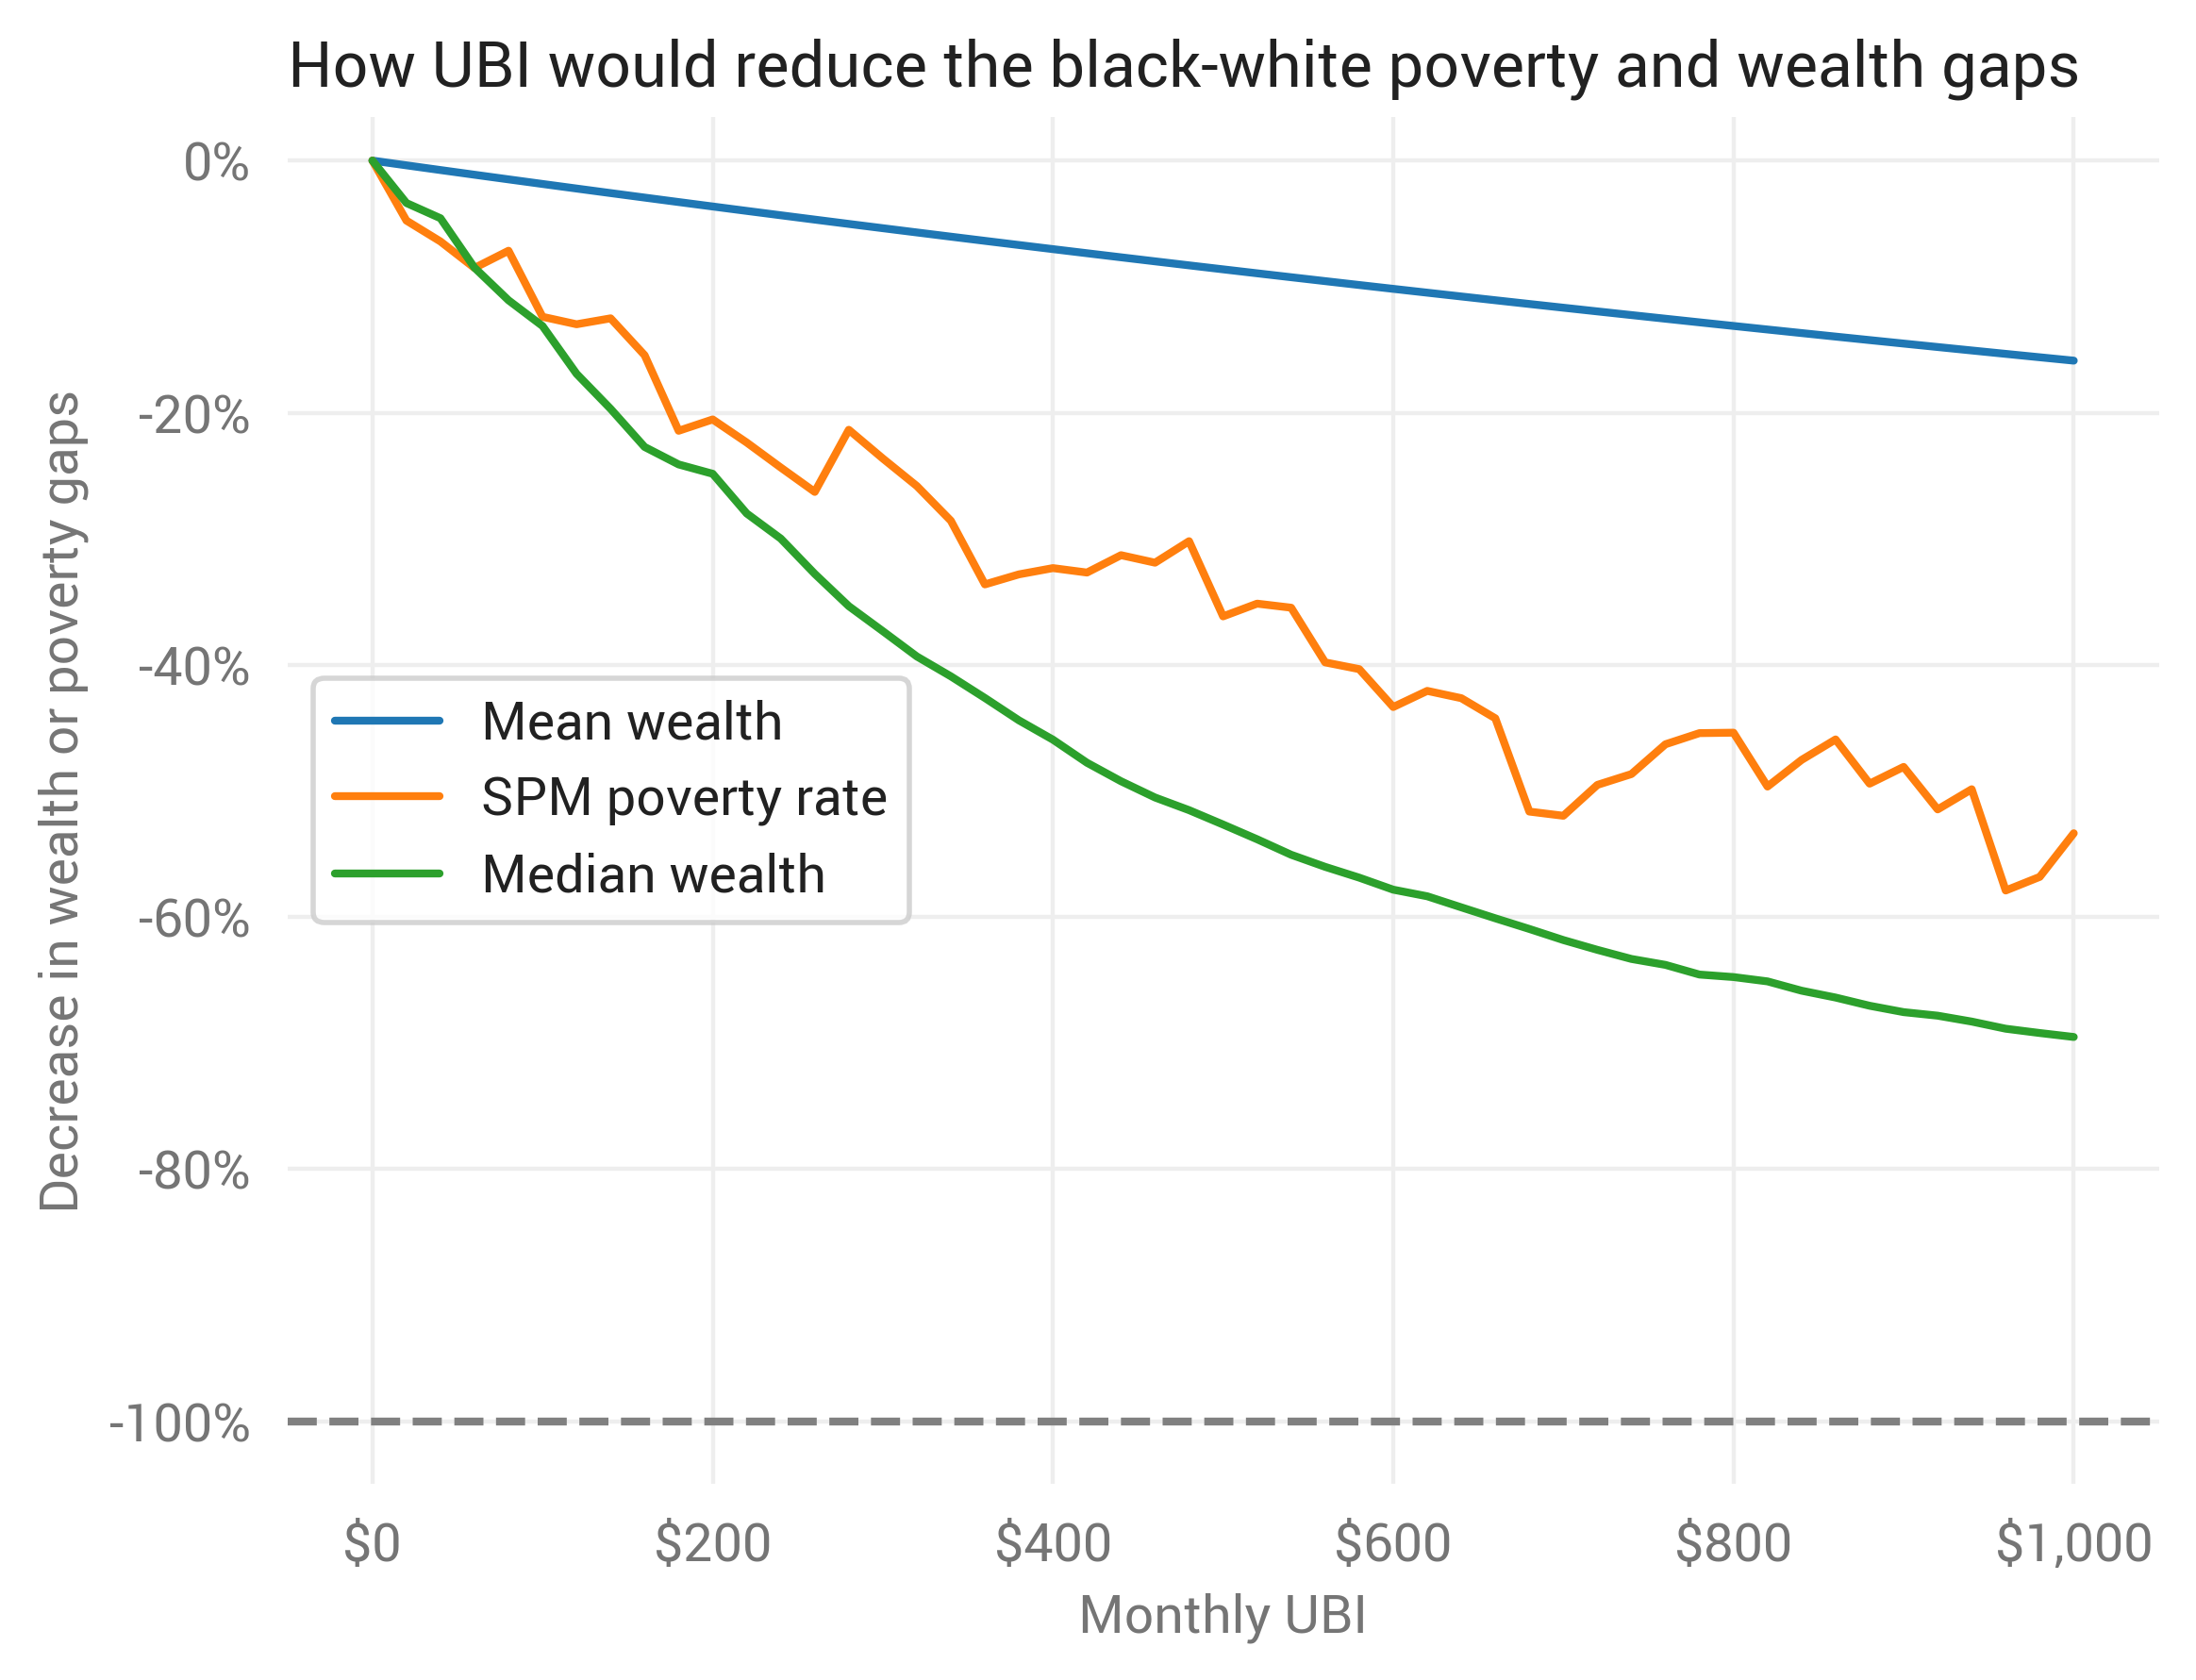

In [27]:
ax = ubi_div[['mean_wealth', 'spm', 'median_wealth']].plot()
plt.title('How UBI would reduce the black-white poverty and wealth gaps',
          loc='left')
plt.legend(['Mean wealth', 'SPM poverty rate', 'Median wealth'])
plt.xlabel('Monthly UBI')
plt.ylim(-1.05, None)
plt.axhline(-1, c='gray', ls='--')
ax.xaxis.set_major_formatter(mdf.dollar_format())
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
plt.ylabel('Decrease in wealth or poverty gaps')
plt.show()

Specific points.

In [28]:
ubi_div.loc[[0, 200, 1000]]

,mean_wealth,median_wealth,spm
ubi_pm,,,
0,0.000000,0.000000,0.000000
200,-0.036416,-0.248449,-0.205354
1000,-0.158702,-0.695250,-0.533624
